<a href="https://colab.research.google.com/github/emretaylanduman/codes_public/blob/master/fastq_kmer_quality_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**K-Mer quality drop assesment tool**

In sequencing devices, some patterns may cause quality score drops, that leads to the quality score differences in that locations. For example, illumina has some soft spot in **GGT** read patterns that causes systematic error in these positions [1]

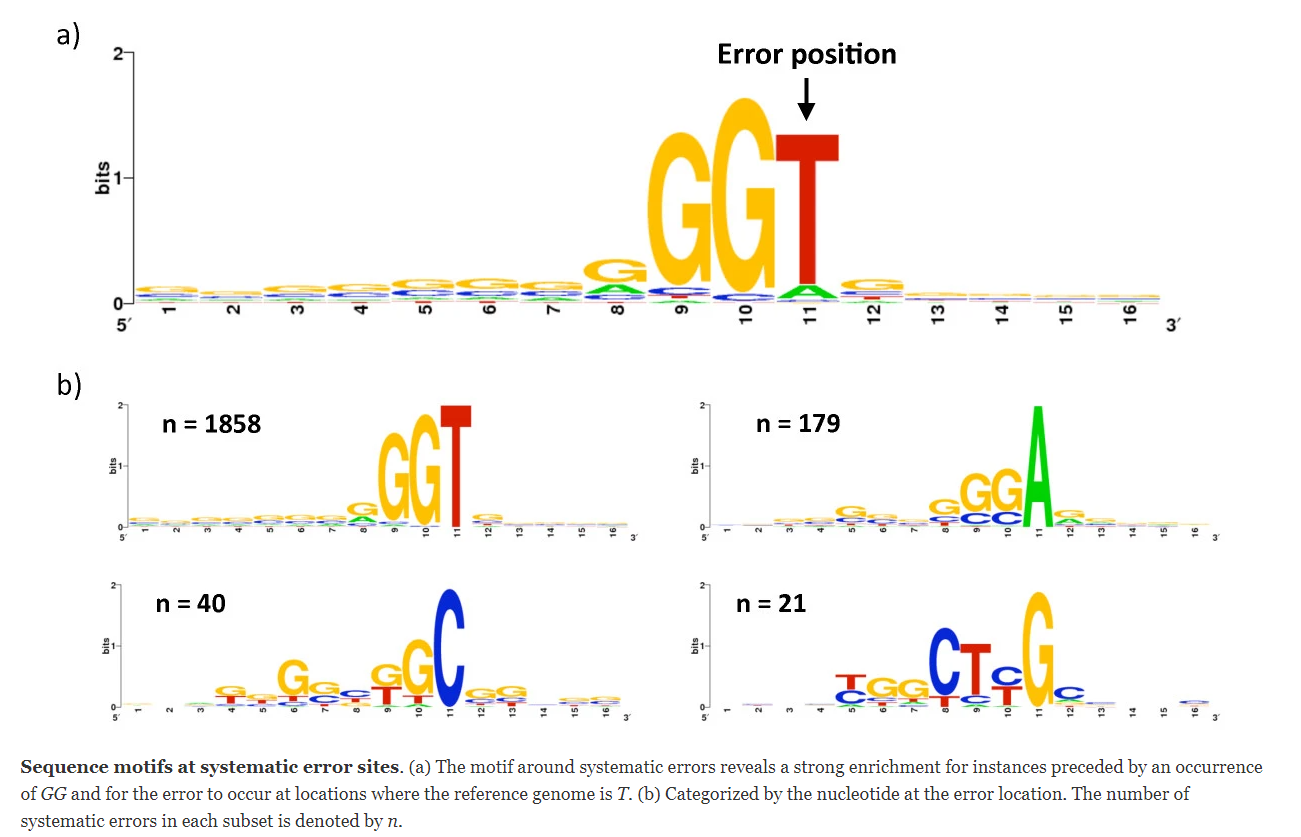




The location of the K-mer and length two of the possible parameters that cause to the quality drops.
This short algorithm focuses on the locations of the k-mers, their overall quality and the difference between the quality of the nucleotide that comes right after that k-mer.

In [ ]:
import re
import pandas as pd
import itertools
import sys

Recursion limit should be increased because the 'readline' code will be called huge amount of times.

Due to the size of the fastq file is large, it is hard to process simultaneously.

In [ ]:
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000000)

Reader is the main function that reads one line from the file and if they  starts with "+SRR and @SRR" calls the function again. It splits the reads and 0th element gives reads or quality scores.

In [ ]:
def reader(file):
    a = file.readline()
    k = a.split('\n')
    if ((k[0][0:4] !='@SRR') and (k[0][0:4] !='+SRR')) :
        k0 = k[0]
        reader(file)
    else:
        k0 = ''
    return(k0)

Count function calculates the size of the nested dictionary that is constructed by the loop down there. 

In [ ]:
def count(d):
    return sum([count(v) if isinstance(v, dict) else 1 for v in d.values()])

mers4 is the list that contains all the possible 4-mer that will be searched for. In this code, 3-mers and 1 nucleotide comes right after is the searching object (4^3 = 64). If we were looking for 2-mers, repeat should be changed into 3. 

In [ ]:
iterable = 'ATGC'
mers4 = list(itertools.product(iterable, repeat=4))
for i in range(len(mers4)):
    mers4[i] = ''.join(mers4[i])

rep variable represents the number of quality score that should be taken for each location in the read. In this code, we took 10 sample for each location in the 200 nucleotide long reads in ther fastq file. If the read length is different, numb variable should be changed. Because we are looking for 4 nucleotide long patterns, our locations are between 4 and 195.

qual_dics is the nested dictionary that we build for each k-mer as keys, and there are one more dictionary that contains each location from 4-195 as keys and 10 values that represents the quality differentiation between the mean score of the k-mer and the k+1 nucleotide.

In [ ]:
rep = 10
numb = 196
qual_dics = dict.fromkeys(mers4, 0)

In [ ]:
file = open('SRR5604260.fastq','r')

When the dictionary constructed above, k-mer keys needs to be changed as dictionaries.

In [ ]:
for kmer in mers4:
    qual_dics[kmer]={}


1.   Because of the blank line in the beginning of the fastq file, it needs to be read once to eliminate that blank line.

2.   When red calls the reader function, it appends first read into the red variable and appends its quality scores into the qual variable.

3. It searches every k-mer in that read and store the locations in locs variable

4. Summry is the converted mean score of the 3-mer that found in that location. -33 is needed for conversion of the PHRED score code into the quality score.

5. Remaining codes fills all the remaining locations and k-mers iteratively.



In [ ]:
file.readline()
while True:
    red = reader(file)
    qual = reader(file)
    if red:
        for kmer in mers4:
            locs = [m.start() for m in re.finditer(kmer, red)]
            if locs:
                for k in locs:
                  summry = ((ord(qual[k]) + ord(qual[k+1]) + ord(qual[k+2]))/3)-33
                  if k < int(len(red))-5:
                    loc = str(k+3)
                    qualty = (ord(qual[k+3]))-33
                    delt = qualty-summry
                    delt = float("{:.2f}".format(delt))
                    if loc in qual_dics[kmer].keys():
                      if len(qual_dics[kmer][loc])<rep:
                        qual_dics[kmer][loc].append(delt)
                      else:
                        continue
                    else:
                      qual_dics[kmer][loc] = [delt]
            alls = count(qual_dics)
            print(alls)
        if alls==rep*numb*64:
            df_qual_drops = pd.DataFrame.from_dict(qual_dics)
            df_qual_drops.index = df_qual_drops.index.astype(int)
            df_qual_drops = df_qual_drops.sort_index(ascending = True)
            file_name = 'all_kmer_quals.xlsx'
            df_qual_drops.to_excel(file_name)
            break   
        else:
            continue
file.close()